# Description

In [1]:
# This data set was used to train a CrowdFlower AI gender predictor. 
# Contributors were asked to simply view a Twitter profile and judge whether 
# the user was a male, a female, or a brand (non-individual). The dataset contains 20,000 rows, each with a user name, 
# a random tweet, account profile and image, location, and even link and sidebar color.
# https://www.kaggle.com/crowdflower/twitter-user-gender-classification/


######### Data #########
# The dataset contains the following fields:

# unitid: a unique id for user
# _golden: whether the user was included in the gold standard for the model; TRUE or FALSE
# unitstate: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
# trustedjudgments: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
# lastjudgment_at: date and time of last contributor judgment; blank for gold standard observations
# gender: one of male, female, or brand (for non-human profiles)
# gender:confidence: a float representing confidence in the provided gender
# profile_yn: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
# profile_yn:confidence: confidence in the existence/non-existence of the profile
# created: date and time when the profile was created
# description: the user's profile description
# fav_number: number of tweets the user has favorited
# gender_gold: if the profile is golden, what is the gender?
# link_color: the link color on the profile, as a hex value
# name: the user's name
# profileyngold: whether the profile y/n value is golden
# profileimage: a link to the profile image
# retweet_count: number of times the user has retweeted (or possibly, been retweeted)
# sidebar_color: color of the profile sidebar, as a hex value
# text: text of a random one of the user's tweets
# tweet_coord: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
# tweet_count: number of tweets that the user has posted
# tweet_created: when the random tweet (in the text column) was created
# tweet_id: the tweet id of the random tweet
# tweet_location: location of the tweet; seems to not be particularly normalized
# user_timezone: the timezone of the user

# Importing libraries

In [1]:
import numpy as np 
import pandas as pd
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read a comma-separated values (csv) file into DataFrame.
twitter_data = pd.read_csv('./Data/gender-classifier-DFE-791531.csv',encoding='latin1')

# EDA

In [4]:
#  Check the dimensionality of the DataFrame
twitter_data.shape

(20050, 26)

In [5]:
twitter_data.dtypes

_unit_id                   int64
_golden                     bool
_unit_state               object
_trusted_judgments         int64
_last_judgment_at         object
gender                    object
gender:confidence        float64
profile_yn                object
profile_yn:confidence    float64
created                   object
description               object
fav_number                 int64
gender_gold               object
link_color                object
name                      object
profile_yn_gold           object
profileimage              object
retweet_count              int64
sidebar_color             object
text                      object
tweet_coord               object
tweet_count                int64
tweet_created             object
tweet_id                 float64
tweet_location            object
user_timezone             object
dtype: object

In [6]:
# Generate descriptive statistics
twitter_data.describe()

,_unit_id,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id
count,2.005000e+04,20050.000000,20024.000000,20050.000000,20050.000000,20050.000000,2.005000e+04,2.005000e+04
mean,8.157294e+08,3.615711,0.882756,0.993221,4382.201646,0.079401,3.892469e+04,6.587350e+17
std,6.000801e+03,12.331890,0.191403,0.047168,12518.575919,2.649751,1.168371e+05,5.000124e+12
min,8.157192e+08,3.000000,0.000000,0.627200,0.000000,0.000000,1.000000e+00,6.587300e+17
25%,8.157243e+08,3.000000,0.677800,1.000000,11.000000,0.000000,2.398000e+03,6.587300e+17
50%,8.157294e+08,3.000000,1.000000,1.000000,456.000000,0.000000,1.144150e+04,6.587300e+17
75%,8.157345e+08,3.000000,1.000000,1.000000,3315.500000,0.000000,4.002750e+04,6.587400e+17
max,8.157580e+08,274.000000,1.000000,1.000000,341621.000000,330.000000,2.680199e+06,6.587400e+17


In [7]:
# Check count of missing values
twitter_data.isnull().sum()

_unit_id                     0
_golden                      0
_unit_state                  0
_trusted_judgments           0
_last_judgment_at           50
gender                      97
gender:confidence           26
profile_yn                   0
profile_yn:confidence        0
created                      0
description               3744
fav_number                   0
gender_gold              20000
link_color                   0
name                         0
profile_yn_gold          20000
profileimage                 0
retweet_count                0
sidebar_color                0
text                         0
tweet_coord              19891
tweet_count                  0
tweet_created                0
tweet_id                     0
tweet_location            7484
user_timezone             7798
dtype: int64

In [3]:
# Count of tweet_count including NA values
twitter_data['tweet_count'].value_counts(dropna=False) 

151386     30
1          26
2372591    24
3          24
2          21
           ..
57126       1
15103       1
13054       1
4858        1
100353      1
Name: tweet_count, Length: 14280, dtype: int64

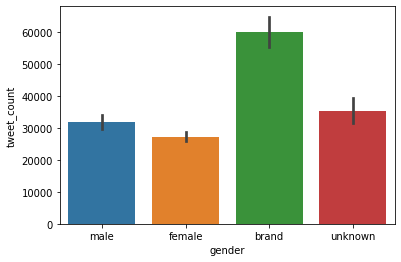

In [9]:
# Barplot of gender and tweet_count
sns.barplot(x='gender', y='tweet_count', data=twitter_data)

In [10]:
twitter_data['gender'].count()

19953

In [4]:
# Count of gender including NA values
twitter_data['gender'].value_counts(dropna=False) 

female     6700
male       6194
brand      5942
unknown    1117
NaN          97
Name: gender, dtype: int64

The frequency of gender in each segment is depicted in the bar plot above. There are 6700 females, 6194 males, 5942 brands, 1117 uncertain values, and 97 missing values.

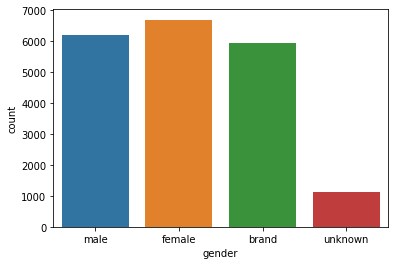

In [5]:
# Count plot of gender
sns.countplot(twitter_data['gender'], label="gender")

# Data Pre-processing

In [6]:
# Create a new dataframe with gender and description
my_data = twitter_data.loc[:,["gender","description"]]
my_data.head()

,gender,description
0,male,i sing my own rhythm.
1,male,I'm the author of novels filled with family dr...
2,male,louis whining and squealing and all
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe..."
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...


In [7]:
# Drop dataFrame with NA entries
my_data.dropna(inplace=True)

In [8]:
my_data['gender'].count()

16224

In [9]:
my_data['gender'].value_counts(dropna=False) 

female     5725
male       5469
brand      4328
unknown     702
Name: gender, dtype: int64

In [10]:
my_data = my_data[my_data.gender != 'unknown']

In [11]:
my_data['gender'].value_counts(dropna=False) 

female    5725
male      5469
brand     4328
Name: gender, dtype: int64

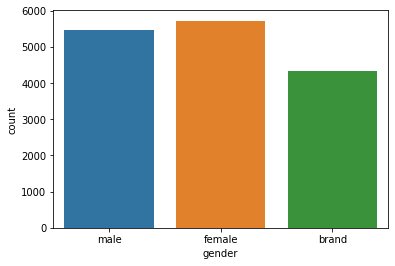

In [17]:
# Count plot for gender after removing unknown and NA values
sns.countplot(my_data['gender'],label="gender")

The above plot shows the frequency of gender after removing unknown and NA values.

In [12]:
# convert gender feature to int
# brand = 0, female = 1, male = 2

my_data.gender = pd.Categorical(my_data.gender)
my_data['gender2'] = my_data.gender.cat.codes
my_data.head(10)

,gender,description,gender2
0,male,i sing my own rhythm.,2
1,male,I'm the author of novels filled with family dr...,2
2,male,louis whining and squealing and all,2
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",2
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,1
5,female,you don't know me.,1
6,brand,"A global marketplace for images, videos and mu...",0
7,male,The secret of getting ahead is getting started.,2
8,female,Pll Fan // Crazy about MCD // Ramen is bae,1
9,female,"Renaissance art historian, University of Notti...",1


In [13]:
# Lemmatizer (nltk library)
lemma = nltk.WordNetLemmatizer() 

In [14]:
description_list = []
for each in my_data.description:
    
    # Remove unnecessary characters from string
    each = re.sub("[^a-zA-Z]"," ",each) 
    # Converting string to lower case
    each = each.lower() 
    # Converting string to list
    each = nltk.word_tokenize(each) 
    # Lemmatizing
    each = [lemma.lemmatize(each) for each in each] 
    # Converting list to string
    each = " ".join(each) 
    # Append the data to list
    description_list.append(each) 

In [15]:
description_list[:10]

['i sing my own rhythm',
 'i m the author of novel filled with family drama and romance',
 'louis whining and squealing and all',
 'mobile guy er shazam google kleiner perkins yahoo sprint pc airtouch air force stanford gsb uva dad husband brother golfer',
 'ricky wilson the best frontman kaiser chief the best band xxxx thank you kaiser chief for an incredible year of gig and memory to cherish always xxxxxxx',
 'you don t know me',
 'a global marketplace for image video and music sharing photo inspiration design tip video for the creative community',
 'the secret of getting ahead is getting started',
 'pll fan crazy about mcd ramen is bae',
 'renaissance art historian university of nottingham fuelled by haribo partial to coffee and with a soft spot for renaissance china national teaching fellow']

In [16]:
# Create a bag of words

# 1000 most used words in description
cv = CountVectorizer(max_features=1000, stop_words='english')

In [17]:
# Construct a sparse matrix
sparse_matrix = cv.fit_transform(description_list).toarray()
sparse_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
x = sparse_matrix
y = my_data.gender2.values
results = []

# Split arrays into training and test
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)

# Naive Bayes Classification Algorithm

In [19]:
# Naive Bayes Classification Algorithm
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(x_train,y_train)
print(NBC.score(x_test,y_test))

0.5619967793880838


In [20]:
results.append(NBC.score(x_test,y_test))
results

[0.5619967793880838]

# Logistic Regression Classification

In [21]:
# Logistic Regression Classification
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train,y_train)
print(LR.score(x_test,y_test))

0.5964573268921095


C:\Users\vedan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
results.append(LR.score(x_test,y_test))
results

[0.5619967793880838, 0.5964573268921095]

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty' : ['l1', 'l2'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','sag','saga'],
    'max_iter' : [100, 500, 1000]
    }
grid_search = GridSearchCV(estimator=LR, cv=10, param_grid=param_grid, verbose=True, n_jobs=-1)
grid_search.fit(x_train,y_train)
grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 6 candidates, totalling 60 fits


In [23]:
LR_new = LogisticRegression(max_iter=500, penalty= 'l2', solver="lbfgs")
LR_new.fit(x_train,y_train)
print(LR_new.score(x_test,y_test))

0.5971014492753624


In [24]:
accuracy_score_after_hyperparameter_tuning = []
accuracy_score_after_hyperparameter_tuning.append(LR_new.score(x_test,y_test))
accuracy_score_after_hyperparameter_tuning

[0.5971014492753624]

# Random Forest Classification

In [25]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(x_train,y_train)
print(RFC.score(x_test,y_test))

0.5768115942028985


In [26]:
results.append(RFC.score(x_test,y_test))
results

[0.5619967793880838, 0.5964573268921095, 0.5768115942028985]

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[2,5,10,20],'min_samples_split':[2,3], 'min_samples_leaf':[1,2,3]}
grid_search = GridSearchCV(estimator=RFC, cv=10, param_grid=param_grid, verbose=True, n_jobs=-1)
grid_search.fit(x_train,y_train)
grid_search.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  8.4min finished


{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}

In [28]:
RFC_new = RandomForestClassifier(min_samples_leaf= 2, min_samples_split= 2, n_estimators= 20)
RFC_new.fit(x_train,y_train)
print(RFC_new.score(x_test,y_test))

0.5848631239935588


In [29]:
accuracy_score_after_hyperparameter_tuning.append(RFC_new.score(x_test,y_test))
accuracy_score_after_hyperparameter_tuning

[0.5971014492753624, 0.5848631239935588]

# Linear Support Vector Classification

In [30]:
# Linear Support Vector Classification
from sklearn.svm import LinearSVC, SVC
SVM_Model = LinearSVC()
SVM_Model.fit(x_train,y_train)
print(SVM_Model.score(x_test,y_test))

0.592914653784219


In [31]:
results.append(SVM_Model.score(x_test,y_test))
results

[0.5619967793880838, 0.5964573268921095, 0.5768115942028985, 0.592914653784219]

# Naive Bayes classifier for multinomial models

In [32]:
# Naive Bayes classifier for multinomial models
from sklearn.naive_bayes import MultinomialNB
MNB_Model = MultinomialNB()
MNB_Model.fit(x_train,y_train)
print(MNB_Model.score(x_test,y_test))

0.6038647342995169


In [33]:
results.append(MNB_Model.score(x_test,y_test))
results

[0.5619967793880838,
 0.5964573268921095,
 0.5768115942028985,
 0.592914653784219,
 0.6038647342995169]

In [34]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha':[0,1], 'class_prior':[None], 'fit_prior':[True, False]}
grid_search = GridSearchCV(estimator=MNB_Model, cv=3, param_grid=param_grid, verbose=True, n_jobs=-1)
grid_search.fit(x_train,y_train)
grid_search.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.2s finished


{'alpha': 1, 'class_prior': None, 'fit_prior': True}

In [35]:
from sklearn.naive_bayes import MultinomialNB
MNB_Model_new = MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
MNB_Model_new.fit(x_train,y_train)
print(MNB_Model_new.score(x_test,y_test))

0.6038647342995169


In [36]:
accuracy_score_after_hyperparameter_tuning.append(MNB_Model_new.score(x_test,y_test))
accuracy_score_after_hyperparameter_tuning

[0.5971014492753624, 0.5848631239935588, 0.6038647342995169]

# Results

Text(0.5, 1.0, 'Barplot for accucracy score of models')

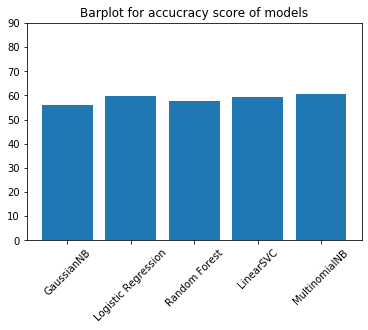

In [37]:
# Barplot before hyperparameter tuning
import matplotlib.pyplot as plt
models = ['GaussianNB', 'Logistic Regression', 'Random Forest', 'LinearSVC', 'MultinomialNB']
percentage_accuracy = [element * 100 for element in results]
plt.bar(models,percentage_accuracy)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,100, 10))
plt.title('Barplot for accucracy score of models')

The accuracy score of the classification models used in the study is seen in the graph above. GaussianNB, Logistic Regression, Random Forest Classification, Linear Support Vector Classification, and Naive Bayes classifiers for multinomial models have percentage accuracy scores of 56.19, 59.64, 58.51, 59.29, and 60.38 respectively. MultinomialNB model shows the highest accuracy of 60.38%

Text(0.5, 1.0, 'Barplot for accucracy score of models after hyperparameter tuning')

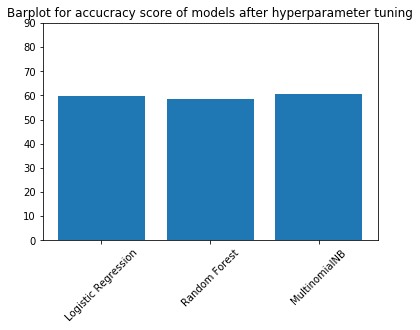

In [38]:
# Barplot after hyperparameter tuning
import matplotlib.pyplot as plt
models = ['Logistic Regression', 'Random Forest', 'MultinomialNB']
accuracy_score_after_hyperparameter_tuning_percentage = [element * 100 for element in accuracy_score_after_hyperparameter_tuning]
plt.bar(models,accuracy_score_after_hyperparameter_tuning_percentage)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,100, 10))
plt.title('Barplot for accucracy score of models after hyperparameter tuning')

Models were optimized using hyperparameter tuning after they were built with default parameters. I optimized Logistic Regression, Random Forest Classification, and Naive Bayes classifiers for multinomial models with 10-fold cross validation using GridSearchCV method. 
Their accuracy percentages are 59.71, 58.51, and 60.38, respectively. 
The same is shown in the bar above graph.

# Conclusion

Different classification models were developed in this analysis, and each model yielded a different accuracy score. Logistic Regression, Random Forest, and MultinomialNB were all used to perform hyperparameter optimization. And I've come to the conclusion that MultinomialNB is the better model, with a 60.38 percent accuracy. I'd also like to point out that even after hyperparameter tuning and 10-fold cross-validation, the best parameters are the same as the default parameter.